# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Flow and geodesics

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

**GPU extraction of geodesics ?**
Solving a low dimensional ODE is a sequential process, and it may seem silly to do it on the GPU.
We make this choice because Python is too slow for that purpose, and CPU C++ code is hard to distribute (needs to be compiled), whereas GPU code is fast and compiled just-in-time. In principle, the code will compute a large number of geodesics in parallel on the GPU if needed.

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Constant metrics](#1.-Constant-metrics)
    * [1.1 Isotropic metrics](#1.1-Isotropic-metrics)
    * [1.2 Riemannian metrics](#1.2-Riemannian-metrics)
    * [1.3 Rander metrics](#1.3-Rander-metrics)
  * [2. Variable metrics](#2.-Variable-metrics)
    * [2.1 Isotropic](#2.1-Isotropic)
    * [2.2 Riemannian](#2.2-Riemannian)
    * [2.3 Rander](#2.3-Rander)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Flow_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Plotting import quiver
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
Eikonal.dictIn.default_mode = 'gpu'

from agd.ExportedCode.Notebooks_GPU.Isotropic_Repro import RunCompare
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

In [4]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
quiver = cugen.cupy_get_args(quiver)

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU
    Eikonal,ad,cugen = rreload([Eikonal,ad,cugen],"../..")
    Eikonal.dictIn.default_mode = 'gpu'

## 1. Constant metrics

When the metric is constant, the geodesic flow is directed toward the seed point, and the geodesic are straight lines.

### 1.1 Isotropic metrics

In [6]:
n=201
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.,0.],
    'exportValues':1,
    'cost':1.,
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.SetUniformTips((4,4))

In [7]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.020490169525146484 seconds, and 10 iterations.
Post-Processing


In [8]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

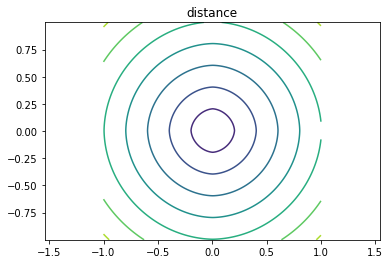

In [9]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

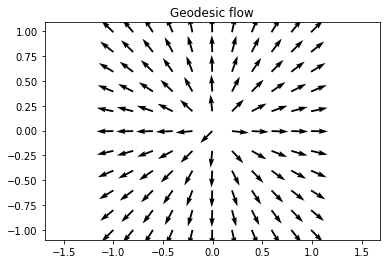

In [10]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*gpuOut['flow'],subsampling=(20,20));

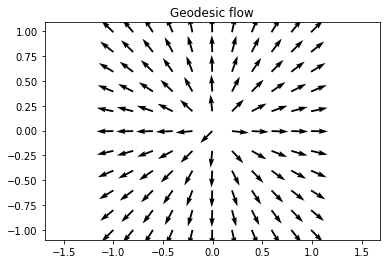

In [11]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*gpuOut['flow'],subsampling=(20,20));

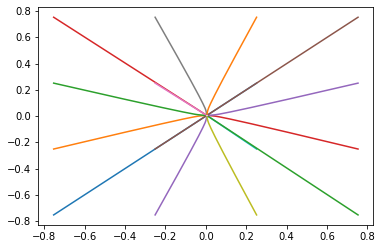

In [12]:
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.2 Riemannian metrics

In [13]:
n=199
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed':[0.,0.],
    'exportValues':1,
    'metric':Metrics.Riemann(cp.array([[1.,1.],[1.,2.]])),
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.SetUniformTips((4,4))

In [14]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)


Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.042000770568847656 seconds, and 71 iterations.
Post-Processing


In [15]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

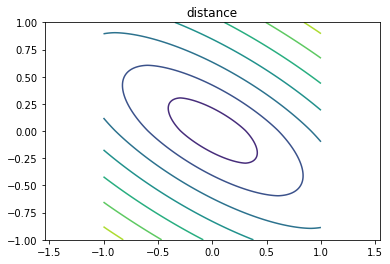

In [16]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

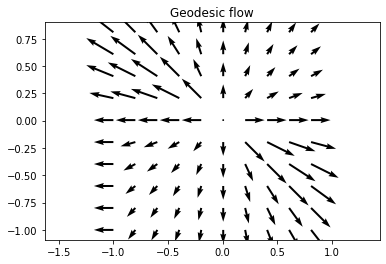

In [17]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*gpuOut['flow'],subsampling=(20,20));

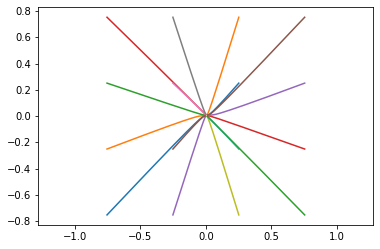

In [18]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 1.3 Rander metrics

In [19]:
n=201
hfmIn = Eikonal.dictIn({
    'model':'Rander2', 'metric':Metrics.Rander(cp.eye(2),cp.array([0.,0.5])),
    'seed':[0.,0.],
    'exportValues':1,
    'exportGeodesicFlow':1,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.SetUniformTips((4,4))

In [20]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.014482975006103516 seconds, and 28 iterations.
Post-Processing


In [21]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=450

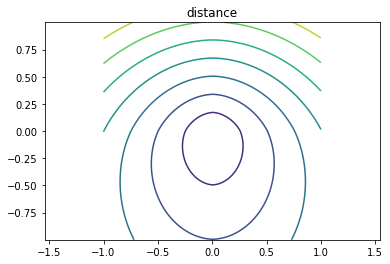

In [22]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

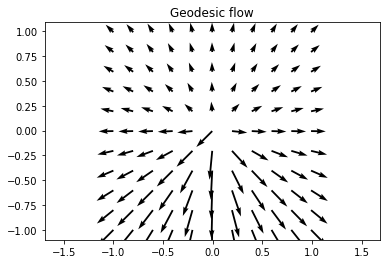

In [23]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*gpuOut['flow'],subsampling=(20,20));

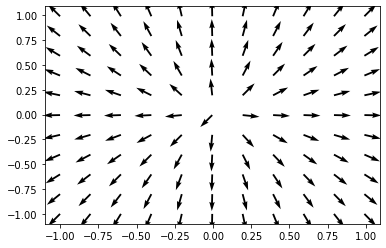

In [24]:
flow=gpuOut['flow'].copy(); flow/=ad.Optimization.norm(flow,axis=0) 
quiver(*X,*flow,subsampling=(20,20));

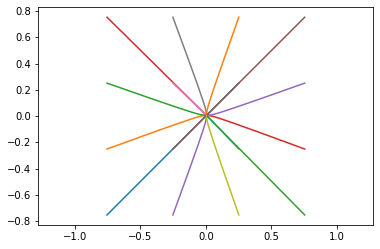

In [25]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

## 2. Variable metrics

We reproduce a few classical test cases from the other notebooks.

### 2.1 Isotropic

In [26]:
n=200; 
hfmIn=Eikonal.dictIn({
    'model':'Isotropic2',
    'exportValues':1,
    'seed':[0.,0.],
    'verbosity':0,
    'exportGeodesicFlow':1,
    'geodesic_hlen':20,    
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()
hfmIn.update({
    'cost':np.prod(np.sin(2*np.pi*X),axis=0) +1.1, # Non-constant cost
    'tips':hfmIn.Grid(dims=(5,4)).reshape(2,-1).T
})

In [27]:
gpuOut = hfmIn.Run()

In [28]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=600

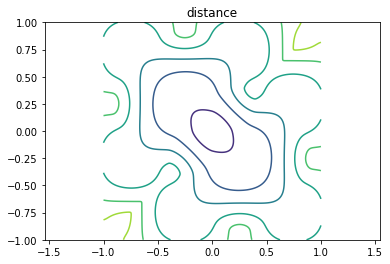

In [29]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

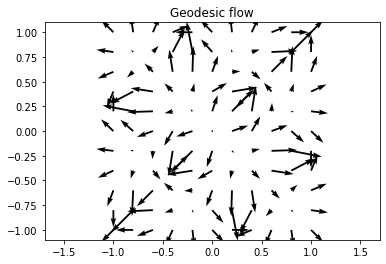

In [30]:
plt.title("Geodesic flow"); plt.axis('equal')
quiver(*X,*gpuOut['flow'],subsampling=(20,20));

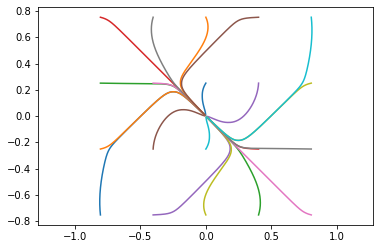

In [31]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

### 2.2 Riemannian

In [32]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'seed':[0.,0.],
    'exportValues':1,
    'exportGeodesicFlow':1,
    'multiprecision':True,
    'traits':{
        'niter_i':16,'shape_i':(8,8), # Best
    },
})
hfmIn.SetRect([[-np.pi,np.pi],[-np.pi,np.pi]],dimx=n+1,sampleBoundary=True)
X = hfmIn.Grid()

rot = fd.as_field(lp.rotation(cp.array(np.pi/6)),X.shape[1:])
def height(x): x=lp.dot_AV(rot,x); return np.sin(x[0])*np.sin(x[1])
def surface_metric(x,z,mu=10.):
    ndim,shape = x.ndim-1,x.shape[1:]
    x_ad = ad.Dense.identity(constant=x,shape_free=(ndim,))
    tensors = lp.outer_self( z(x_ad).gradient() ) + mu**-2 * fd.as_field(cp.eye(ndim),shape)
    return Metrics.Riemann(tensors)

hfmIn['metric'] = surface_metric(X,height,mu=10)
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

In [33]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel


Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.034993648529052734 seconds, and 76 iterations.
Post-Processing


In [34]:
assert all(stop == 'AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=550

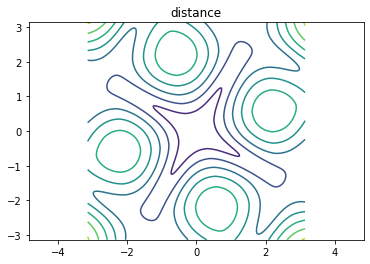

In [35]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

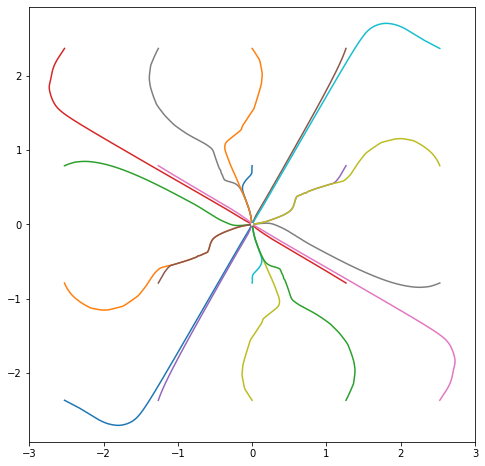

In [36]:
plt.figure(figsize=(8,8)); plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);

The geodesics display a rather surprising angle. However, it is reproduced by the cpu variant, with the ODE solver, and by the python streamplot command. (The cpu discrete geodesic solver does not show this behavior, but it possibly over-smoothes the result.)

<!---
, which is not visible in the cpu variant. However the values and flow coincide with good precision, and a streamplot reproduces the gpu geodesics behavior. This divergence may be explained by the already strong anisotropy, and rather wide stencils used.
--->

<!---
plt.figure(figsize=(16,16)); plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);
flow=cpuOut['flow']; flow = flow/ad.Optimization.norm(flow,axis=0)
s=2; plt.quiver(*X[:,::s,::s],*flow[:,::s,::s]);
--->

In [37]:
#cpuIn = hfmIn.copy()
#for key in ('array_float_caster','traits'): cpuIn.pop(key,None)
#cpuIn['geodesicSolver']='ODE'
cpuOut = hfmIn.Run(join={'mode':'cpu_transfer','geodesicSolver':'ODE'})

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.045 s.
Field geodesicStep defaults to 0.25
Field geodesicCausalityTolerance defaults to 4
Field geodesicTargetTolerance defaults to 6
***** Warning ! *****
Unused fields from user: multiprecision 
********************


In [38]:
cpuOut.keys()

dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'flow', 'geodesics', 'nAccepted', 'unusedFromCompute', 'unusedFromUser', 'unusedHelp', 'values', 'visitedUnset', 'retcode'])

In [39]:
norm_infinity(cpuOut['values']-gpuOut['values'].get())

2.29300033627311e-07

In [40]:
norm_infinity(cpuOut['flow']-gpuOut['flow'].get())

0.00022420209407481018

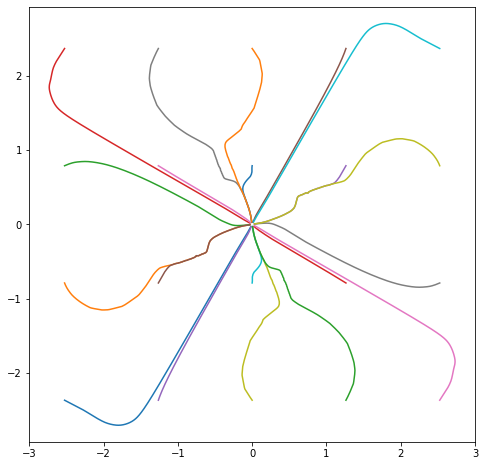

In [41]:
plt.figure(figsize=(8,8)); plt.axis('equal')
for geo in cpuOut['geodesics']: plt.plot(*geo);

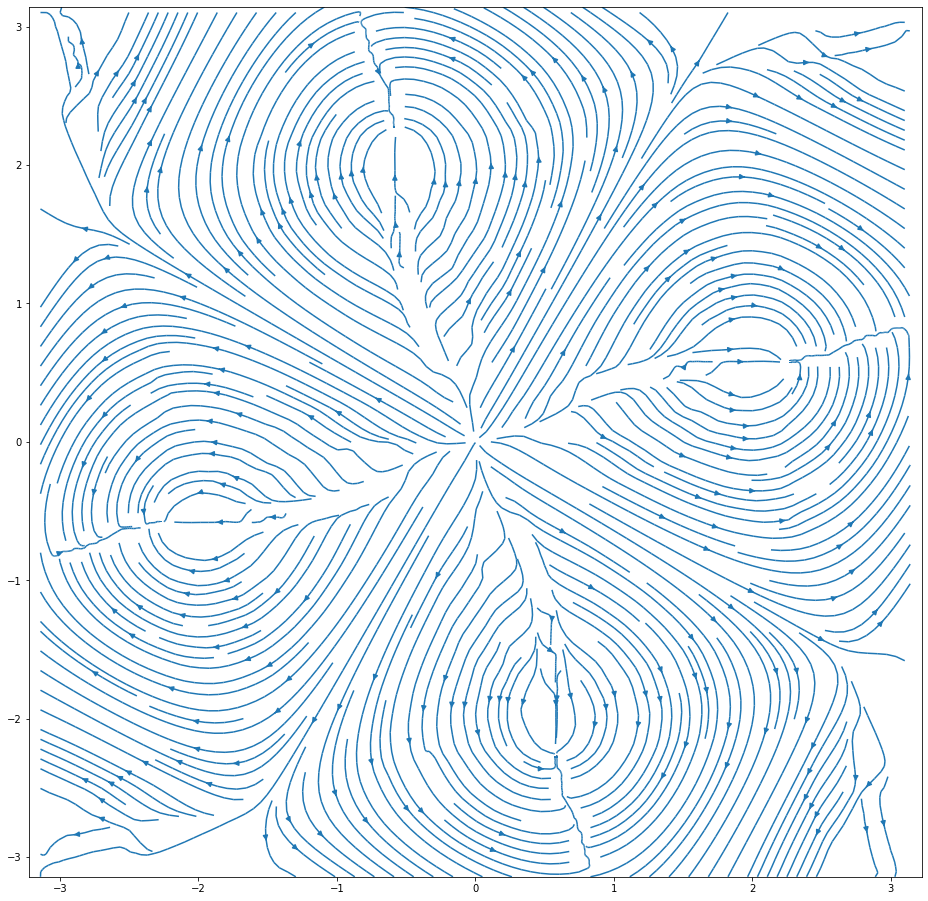

In [42]:
plt.figure(figsize=(16,16)); plt.axis('equal')
streamplot_ij(*X.get(),*cpuOut['flow'],density=3);

### 2.3 Rander

In [43]:
hfmIn = Eikonal.dictIn({
    'model':'Rander2',
    'seed':[0.,0.],
    'exportValues':1,
})
hfmIn.SetRect([[-2.*np.pi,2.*np.pi],[-2.*np.pi,2.*np.pi]],dimx=n+1)
X = hfmIn.Grid()

def Drift(x):
    mult = 0.9*np.sin(x[0])*np.sin(x[1]) / np.linalg.norm(x,axis=0)
    mult[np.isnan(mult)]=0.
    return mult*x

hfmIn['metric']=Metrics.Rander.from_Zermelo(cp.eye(2),Drift(X))
hfmIn['tips']=hfmIn.Grid(dims=(5,4)).reshape(2,-1).T

In [44]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.02199578285217285 seconds, and 40 iterations.
Post-Processing


In [45]:
assert all(stop in ('AtSeed','VanishingFlow') for stop in gpuOut['geodesic_stopping_criteria'])
assert max([len(geo.T) for geo in gpuOut['geodesics']])<=600

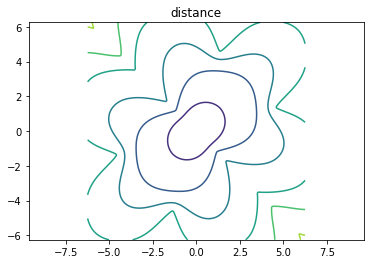

In [46]:
plt.title('distance'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

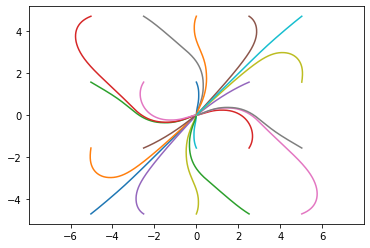

In [47]:
plt.axis('equal')
for geo in gpuOut['geodesics']: plt.plot(*geo);